# Function Summarization Evaluation

In [1]:
%pip install datasets transformers sentence_transformers pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
from transformers import T5ForConditionalGeneration, RobertaTokenizer
from sentence_transformers import SentenceTransformer, util

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset = load_dataset("code_x_glue_ct_code_to_text", "python")

Found cached dataset code_x_glue_ct_code_to_text (/Users/cjwilliams/.cache/huggingface/datasets/code_x_glue_ct_code_to_text/python/0.0.0/f8b7e9d51f609a87e7ec7c7431706d4ee0b402e3398560410313d4acc67060a0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(dataset['test'])

In [6]:
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")
model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-base-multi-sum")
cosine_model = SentenceTransformer("sentence-transformers/multi-qa-distilbert-cos-v1")
finetuned_model = T5ForConditionalGeneration.from_pretrained(
    "cjwilliams/codet5_base_python_sum")
finetuned_model_small = T5ForConditionalGeneration.from_pretrained(
    "stmnk/codet5-small-code-summarization-python")

In [7]:
counter = 1
counter_fine = 1
counter_fine_small = 1
size = len(df)

In [8]:
def summarize(code_tokens):
    global counter, size
    print(f"Base {counter}/{size}")
    counter += 1
    input_ids = tokenizer(' '.join(code_tokens), return_tensors='pt').input_ids
    generated_ids = model.generate(input_ids, max_length=200)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [9]:
def summarize_finetuned(code_tokens):
    global counter_fine, size
    print(f"Fine tuned {counter_fine}/{size}")
    counter_fine += 1
    input_ids = tokenizer(' '.join(code_tokens), return_tensors='pt').input_ids
    generated_ids = finetuned_model.generate(input_ids, max_length=200)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [10]:
def summarize_finetuned_small(code_tokens):
    global counter_fine_small, size
    print(f"Small fine tuned {counter_fine_small}/{size}")
    counter_fine_small += 1
    input_ids = tokenizer(' '.join(code_tokens), return_tensors='pt').input_ids
    generated_ids = finetuned_model_small.generate(input_ids, max_length=200)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [11]:
%%time
df['summarization'] = df['code_tokens'].apply(summarize)
df['summarization_finetuned'] = df['code_tokens'].apply(summarize_finetuned)
df['summarization_finetuned_small'] = df['code_tokens'].apply(summarize_finetuned_small)

Base 1/14918
Base 2/14918
Base 3/14918
Base 4/14918
Base 5/14918
Base 6/14918
Base 7/14918
Base 8/14918
Base 9/14918
Base 10/14918


Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Base 11/14918
Base 12/14918
Base 13/14918
Base 14/14918
Base 15/14918
Base 16/14918
Base 17/14918
Base 18/14918
Base 19/14918
Base 20/14918
Base 21/14918
Base 22/14918
Base 23/14918
Base 24/14918
Base 25/14918
Base 26/14918
Base 27/14918
Base 28/14918
Base 29/14918
Base 30/14918
Base 31/14918
Base 32/14918
Base 33/14918
Base 34/14918
Base 35/14918
Base 36/14918
Base 37/14918
Base 38/14918
Base 39/14918
Base 40/14918
Base 41/14918
Base 42/14918
Base 43/14918
Base 44/14918
Base 45/14918
Base 46/14918
Base 47/14918
Base 48/14918
Base 49/14918
Base 50/14918
Base 51/14918
Base 52/14918
Base 53/14918
Base 54/14918
Base 55/14918
Base 56/14918
Base 57/14918
Base 58/14918
Base 59/14918
Base 60/14918
Base 61/14918
Base 62/14918
Base 63/14918
Base 64/14918
Base 65/14918
Base 66/14918
Base 67/14918
Base 68/14918
Base 69/14918
Base 70/14918
Base 71/14918
Base 72/14918
Base 73/14918
Base 74/14918
Base 75/14918
Base 76/14918
Base 77/14918
Base 78/14918
Base 79/14918
Base 80/14918
Base 81/14918
Base 8

In [12]:
def compare(summarization, docstring):
    embedding_1 = cosine_model.encode(summarization)
    embedding_2 = cosine_model.encode([docstring, ""])
    score = util.dot_score(embedding_1, embedding_2)[0].cpu().tolist()[0]
    return score

In [13]:
df['score'] = df.apply(lambda x: compare(x.summarization, ' '.join(x.docstring_tokens)), axis=1)
df['finetuned_score'] = df.apply(
    lambda x: compare(x.summarization_finetuned, ' '.join(x.docstring_tokens)), axis=1)
df['finetuned_small_score'] = df.apply(
    lambda x: compare(x.summarization_finetuned_small, ' '.join(x.docstring_tokens)), axis=1)

In [19]:
df['score'].median()

0.5857313275337219

In [20]:
df['finetuned_score'].median()

0.3593127131462097

In [21]:
df['finetuned_small_score'].median()

0.4564909487962723

In [87]:
df.to_csv("results.csv", sep=',', encoding='utf-8')

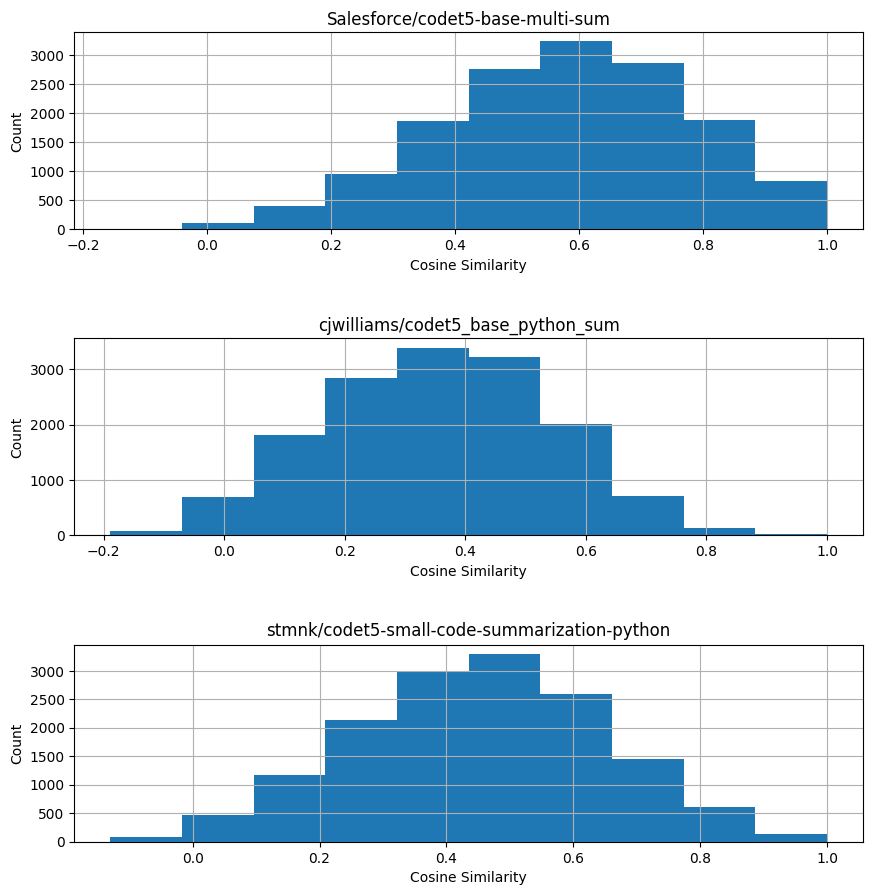

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10))
df.loc[:, "score"].hist(ax=ax1)
df.loc[:, "finetuned_score"].hist(ax=ax2)
df.loc[:, "finetuned_small_score"].hist(ax=ax3)
fig.tight_layout(pad=6.0)
ax1.set_title("Salesforce/codet5-base-multi-sum")
ax2.set_title("cjwilliams/codet5_base_python_sum")
ax3.set_title("stmnk/codet5-small-code-summarization-python")
ax1.set_xlabel("Cosine Similarity")
ax2.set_xlabel("Cosine Similarity")
ax3.set_xlabel("Cosine Similarity")
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")
ax3.set_ylabel("Count")
fig.savefig("summarization-performance-histogram.png", bbox_inches='tight')

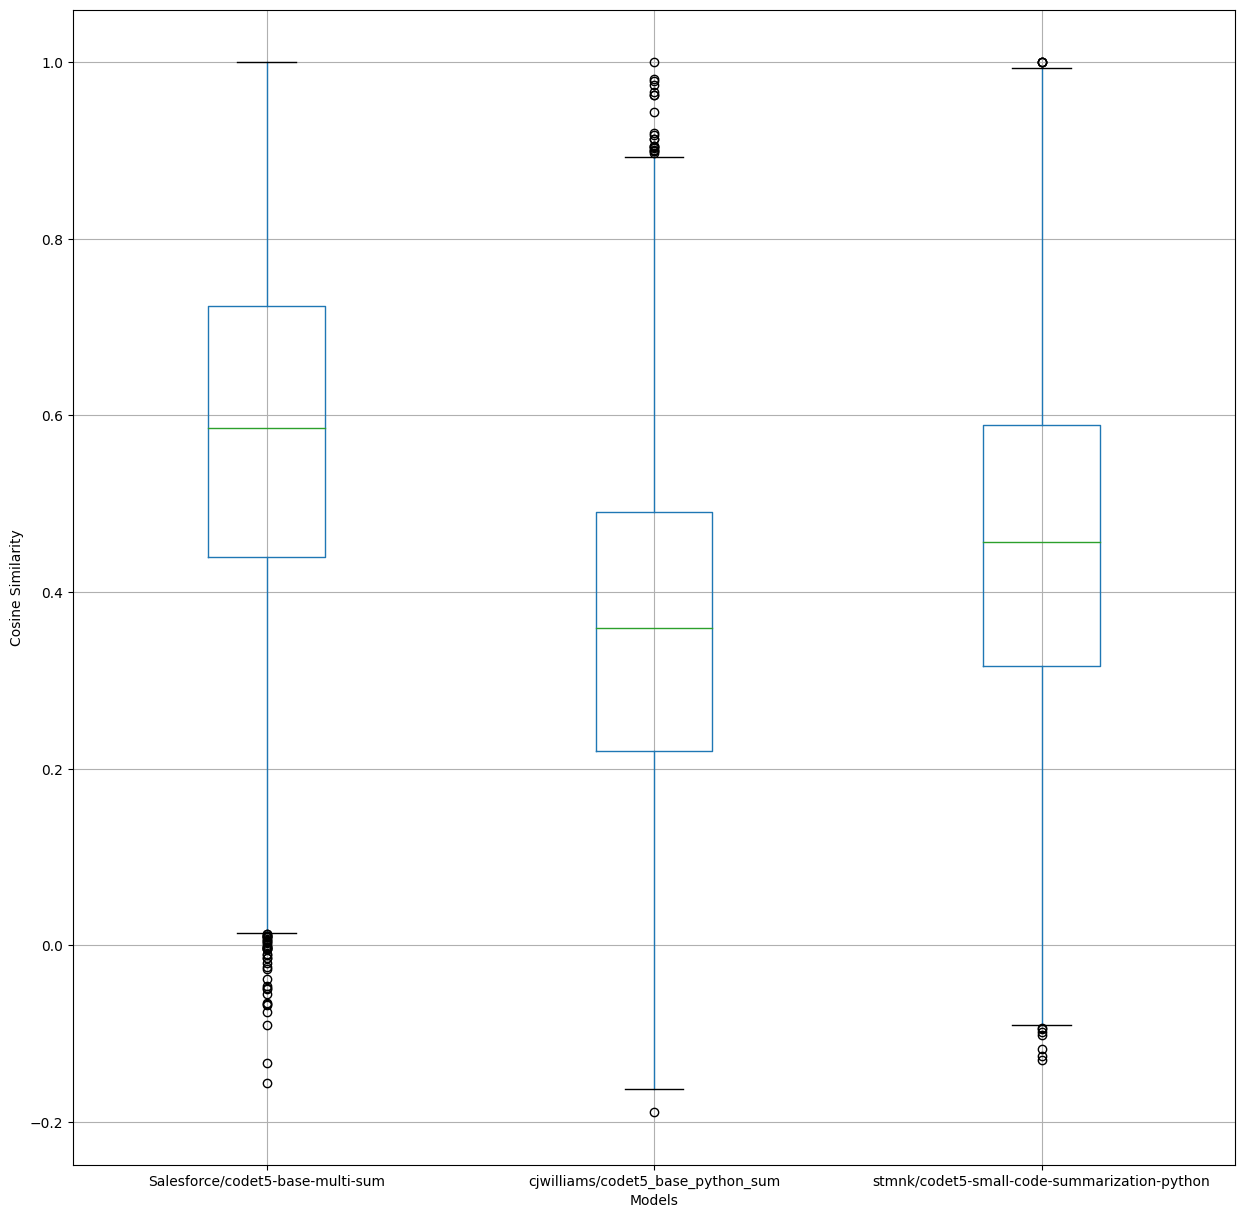

In [29]:
fig, ax = plt.subplots(1, figsize=(15,15))
df.rename(columns={"score": "Salesforce/codet5-base-multi-sum", "finetuned_score": "cjwilliams/codet5_base_python_sum", "finetuned_small_score": "stmnk/codet5-small-code-summarization-python"}).boxplot(column=['Salesforce/codet5-base-multi-sum', 'cjwilliams/codet5_base_python_sum', 'stmnk/codet5-small-code-summarization-python'], ax=ax)
ax.set_ylabel("Cosine Similarity")
ax.set_xlabel("Models")
fig.savefig("summarization-performance-boxplot.png", bbox_inches='tight')